select the best 3 features, 
The top-3 features you find and how you find it

How you evaluate your model

All models you have tried and the result

<font color=red>Plot the learning curve</font> of your best model and 

<font color=red>tell if it is over-fit or not</font>

A brief report what you do in this assignment


In [56]:
# load data, standardize , split training and testing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


X = pd.read_csv('./data/nba/X_train.csv')
Y = pd.read_csv('./data/nba/y_train.csv')
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X)

X_t = pd.read_csv('./data/nba/X_test.csv')
sc.fit(X_t)
X_test = sc.transform(X_test)

print(X.shape)
print(X.columns)
print(y_train.columns)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_std, Y, test_size=0.3, random_state=0)

(52399, 8)
Index(['PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST'],
      dtype='object')
Index(['FGM'], dtype='object')


In [84]:
# Random forest feature select
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=100, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

print(X.columns.values[indices[:3]])


C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


['SHOT_DIST' 'GAME_CLOCK' 'SHOT_CLOCK']


In [86]:
forest.fit(X_train[:,indices[:3]], y_train)
y_pred = forest.predict(X_train[:,indices[:3]])
print('Train Accuracy: %.2f' % accuracy_score(y_pred, y_train))
y_pred = forest.predict(X_valid[:,indices[:3]])
print('Valid Accuracy: %.2f' % accuracy_score(y_pred, y_valid))



C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Train Accuracy: 1.00
Valid Accuracy: 0.56


In [98]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X_train[:,indices[:3]], y_train)
print('\n[Ordinary least square]')

y_pred = np.round(slr.predict(X_train[:,indices[:3]]))

print('Train Accuracy: %.2f' % accuracy_score(y_pred, y_train))
y_pred =np.round(slr.predict(X_valid[:,indices[:3]]))

print('Valid Accuracy: %.2f' % accuracy_score(y_pred, y_valid))


[Ordinary least square]
Train Accuracy: 0.60
Valid Accuracy: 0.60



[Alpha = 0.000001]
MSE train: 0.2345631

[Alpha = 0.000100]
MSE train: 0.2345632

[Alpha = 0.010000]
MSE train: 0.2346781

[Alpha = 1.000000]
MSE train: 0.2479881


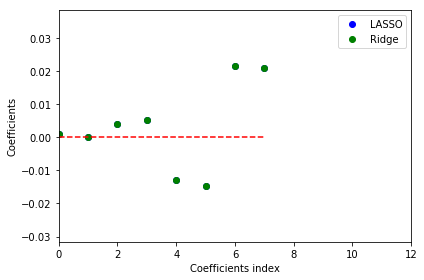

Selected attributes: ['SHOT_DIST' 'PTS_TYPE' 'CLOSE_DEF_DIST'] (array([5, 6, 7], dtype=int64),)


In [81]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

for a in [0.000001, 0.0001, 0.01, 1]:
    lr_rg = Lasso(alpha=a)
    lr_rg.fit(X_train, y_train)

    y_train_pred = lr_rg.predict(X_train)
    y_test_pred = lr_rg.predict(X_test)

    print('\n[Alpha = %.6f]' % a )
    print('MSE train: %.7f' % (mean_squared_error(y_train, y_train_pred))) 
var_num = X_train.shape[1]

lr_lasso = Lasso(alpha =  0.000001)
lr_lasso.fit(X_train, y_train)
lr_ridge = Ridge(alpha = 1)
lr_ridge.fit(X_train, y_train)

plt.scatter(range(var_num),lr_lasso.coef_, label = 'LASSO', color = 'blue')
plt.scatter(range(var_num),lr_ridge.coef_, label = 'Ridge', color = 'green')
plt.hlines(y=0, xmin=0, xmax=var_num-1, color='red', linestyle ='--')
plt.xlim(0,12)
plt.legend(loc = 'upper right')
plt.xlabel('Coefficients index')
plt.ylabel('Coefficients')
plt.tight_layout()
plt.show()

epsilon = 1.3e-2
idxs = np.where(abs(lr_lasso.coef_) > epsilon)
print('Selected attributes: {}'.format(X.columns.values[idxs]),idxs)

In [154]:
#Attempt to eliminate the outlier using randsac
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), 
            max_trials=40, 
            min_samples=10, 
            residual_threshold=6.0, 
            random_state=0)

ransac.fit(X_train, y_train)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
X_train_masked = X_train[inlier_mask]
y_train_masked = y_train[inlier_mask]

print('Train samples eliminated:',sum(outlier_mask),'/',len(X_train))

ransac.fit(X_valid, y_valid)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
X_valid_masked = X_valid[inlier_mask]
y_valid_masked = y_valid[inlier_mask]

print('Valid samples eliminated:',sum(outlier_mask),'/',len(X_valid))

Train samples eliminated: 21 / 36679
Valid samples eliminated: 1 / 15720


In [163]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
poly = PolynomialFeatures(degree=3)


X_train_selected = X_train_masked[:,indices[:3]]
X_trans = poly.fit_transform(X_train_selected)

slr = slr.fit(X_trans, y_train_masked)

print('\n[Ordinary least square]')
y_pred = np.round(slr.predict(X_trans))
print('Train Accuracy: %.2f' % accuracy_score(y_pred, y_train_masked))

X_valid_selected = X_valid_masked[:,indices[:3]]
X_trans = poly.fit_transform(X_valid_selected)

y_pred =np.round(slr.predict(X_trans))
print('Valid Accuracy: %.2f' % accuracy_score(y_pred, y_valid_masked))


[Ordinary least square]
Train Accuracy: 0.61
Valid Accuracy: 0.61


In [ ]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.00007, n_iter=40, random_state=1,n_cell=20):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=n_cell)
        self.cost_ = []
        self.n_cell = n_cell
        
    def fit(self, X, y):
 
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [3]:
def pd2np(df):
    return df.as_matrix()
X_train = pd2np(X_train)
y_train = pd2np(y_train)
X_test = pd2np(X_test)
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(52399, 8)


C:\Users\a1989\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [71]:
print(X[20:30])
print(Y[20:30])

    PERIOD  GAME_CLOCK  SHOT_CLOCK  DRIBBLES  TOUCH_TIME  SHOT_DIST  PTS_TYPE  \
20       3         162         6.0         0         0.8       23.7         3   
21       2         269        18.6         0         1.6       25.0         3   
22       1         624        19.8         1         0.7        9.6         2   
23       2         527         9.5         0         0.6        3.4         2   
24       1         358        19.0         0         0.9       23.8         3   
25       1         150        15.8         0         0.9       20.6         2   
26       1         258        15.7         0         0.7        3.0         2   
27       2         444         9.7        19        13.9       10.2         2   
28       4         191        13.2         0         0.7        3.4         2   
29       4         469        12.5         2         3.7        5.3         2   

    CLOSE_DEF_DIST  
20             5.3  
21             6.5  
22             1.9  
23             4.0  
24 